# Chatbot
* Make the chatbot so that you classify a category (i.e., tag) of input text
    * Return a dialog from the correct class
    * Note that one question could have multiple tags and you may need to simplify
* Alternatively, make a sequence to sequence network that automatically learns what to respond
    * It can be character based or word based
* Hint:  Start with a subset of the dataset
---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from nltk.stem import *

import re
import random
np.random.seed(7)

## Load into dataframes

In [2]:
questions_df = pd.read_csv("./archive/Questions.csv")
answers_df = pd.read_csv("./archive/Answers.csv")
tags_df = pd.read_csv("./archive/Tags.csv")

In [3]:
questions_df.head(15)
#questions_df.describe()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...
5,742,189.0,2008-08-03T15:55:28Z,30,Class views in Django,"<p><a href=""http://www.djangoproject.com/"">Dja..."
6,766,1384652.0,2008-08-03T17:44:07Z,20,Python and MySQL,<p>I can get Python to work with Postgresql bu...
7,773,207.0,2008-08-03T18:27:09Z,256,How do I use Python's itertools.groupby()?,<p>I haven't been able to find an understandab...
8,972,145.0,2008-08-04T02:17:51Z,364,Adding a Method to an Existing Object Instance,<p>I've read that it is possible to add a meth...
9,1476,92.0,2008-08-04T18:20:36Z,251,How do you express binary literals in Python?,<p>How do you express an integer as a binary n...


In [4]:
answers_df.head(15)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."
5,595,116.0,2008-08-03T01:17:36Z,594,25,<p>The canonical way is to use the built-in cu...
6,660,197.0,2008-08-03T12:09:18Z,535,14,<p>Second the Buildbot - Trac integration. You...
7,701,111.0,2008-08-03T14:30:50Z,683,3,"<p>No, you were not dreaming. Python has a pr..."
8,735,145.0,2008-08-03T15:47:22Z,683,-2,<p>I think:</p>\n\n<pre><code>#!/bin/python<br...
9,745,154.0,2008-08-03T15:59:19Z,683,8,<p>Are you looking to get a list of objects th...


In [5]:
tags_df.dropna(inplace=True)
tags_df.head(15)
#tags_df.nunique()
#tags_df.count()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python
5,502,windows
6,502,image
7,502,pdf
8,535,python
9,535,continuous-integration


In [6]:
print("Questions:\t", len(questions_df))
print("Answers:\t", len(answers_df))
print("Tags:\t\t", len(tags_df))
print("\nThese must be the same size!")

Questions:	 607282
Answers:	 987122
Tags:		 1884635

These must be the same size!


---
## Assumptions and decisions
* Drop questions without answers
* Only keep the top answer (the one with the most votes)
* As all questions are related to python, `python` is not a relevant tag
    * Drop all tags with `Tag='python'`
    * Only keep the first tag per `Id` for easier classification
* **The question, answer, and tag lists must have the same size**
    * All questions must have an answer and a tag
    * One answer per question
    * One tag per question

In [7]:
n_tags = 20

In [8]:
# Drop questions without answers
questions_with_answer = questions_df[questions_df['Id'].isin(answers_df['ParentId'])]
print("Questions with answers:", len(questions_with_answer))

Questions with answers: 539238


In [9]:
# Drop all python tags
no_python_tags = tags_df[tags_df['Tag'] != 'python']

# Keep the top 20 tags
top_tags = no_python_tags.groupby('Tag')['Id'].nunique().sort_values(ascending=False).head(n_tags)
top_tags = top_tags.reset_index()
top_tags.rename(columns={"Id": "Count"}, inplace=True)
top_tags

# Create a df for tags that will be used when merging to question
no_dup_tags = no_python_tags.drop_duplicates(subset='Id')

In [10]:
# Drop answers that no longer have questions
answers_with_questions = answers_df[answers_df['ParentId'].isin(questions_with_answer['Id'])]

# Keep the answer with the highest score, sort them by question ID
grouped_answers = answers_with_questions.sort_values(['Score'], ascending=False).groupby('ParentId').head(1)
sorted_answers = grouped_answers.sort_values(['ParentId'])
print("Top answers: ", len(sorted_answers))

Top answers:  539238


In [11]:
def clean_html(raw_html):
    cleanr = re.compile("<.*?>")
    clean_text = re.sub(cleanr, "", raw_html)
    return clean_text

In [17]:
full_questions = pd.merge(questions_with_answer, no_dup_tags, on='Id')
full_questions = pd.merge(full_questions, sorted_answers, left_on='Id', right_on='ParentId')
full_questions.rename(columns={"Id_x": "id", "Title": "title", "Body_x": "body", "Tag": "tag", "Body_y": "answer"}, inplace=True)
full_questions.drop(columns=["OwnerUserId_x", "CreationDate_x", "Score_x", "Id_y", "OwnerUserId_y", "CreationDate_y", "ParentId", "Score_y"], inplace=True)
full_questions['body'] = full_questions['body'].map(lambda question: clean_html(question))
full_questions['answer'] = full_questions['answer'].map(lambda answer: clean_html(answer))
full_questions.head(10)

,id,title,body,tag,answer
0,469,How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...,osx,Unfortunately the only API that isn't deprecat...
1,502,Get a preview JPEG of a PDF on Windows?,I have a cross-platform (Python) application w...,windows,ImageMagick delegates the PDF->bitmap conversi...
2,535,Continuous Integration System for a Python Cod...,I'm starting work on a hobby project with a py...,continuous-integration,One possibility is Hudson. It's written in Ja...
3,594,cx_Oracle: How do I iterate over a result set?,There are several ways to iterate over a resul...,sql,The canonical way is to use the built-in curso...
4,683,Using 'in' to match an attribute of Python obj...,I don't remember whether I was dreaming or not...,arrays,Using a list comprehension would build a tempo...
5,742,Class views in Django,"Django view points to a function, which can be...",django,I've created and used my own generic view clas...
6,766,Python and MySQL,I can get Python to work with Postgresql but I...,mysql,MySQLdb is what I have used before.\n\nIf you ...
7,773,How do I use Python's itertools.groupby()?,I haven't been able to find an understandable ...,iteration,"As Sebastjan said, you first have to sort your..."
8,972,Adding a Method to an Existing Object Instance,I've read that it is possible to add a method ...,oop,"In Python, there is a difference between funct..."
9,1476,How do you express binary literals in Python?,How do you express an integer as a binary numb...,syntax,For reference&mdash;future Python possibilitie...


* To prevent bias, select a random sample of 500 questions from each tag

In [18]:
question_samples = pd.DataFrame(columns=full_questions.columns)
tags = []

for i, tag_item in enumerate(top_tags.values):
    tag = tag_item[0]
    q_count = full_questions[full_questions['tag'] == tag]['tag'].count()
    print(i, tag, q_count)
    if q_count < 500:
        continue
    sample = full_questions[full_questions['tag'] == tag].sample(500)
    tags.append(tag)
    question_samples = question_samples.append(sample)

0 django 48128
1 python-2.7 21239
2 pandas 15826
3 python-3.x 14810
4 numpy 13281
5 list 15310
6 matplotlib 8781
7 regex 13011
8 dictionary 5836
9 tkinter 4249
10 string 8552
11 flask 3946
12 google-app-engine 7134
13 csv 5427
14 arrays 8264
15 json 5892
16 mysql 6239
17 linux 5403
18 html 5435
19 scipy 1471


In [19]:
print(tags)
print(len(question_samples), "questions in distributed set")

['django', 'python-2.7', 'pandas', 'python-3.x', 'numpy', 'list', 'matplotlib', 'regex', 'dictionary', 'tkinter', 'string', 'flask', 'google-app-engine', 'csv', 'arrays', 'json', 'mysql', 'linux', 'html', 'scipy']
10000 questions in distributed set


In [20]:
df_questions = question_samples.sample(frac=1).reset_index(drop=True)
num_questions = len(df_questions)
df_questions.head(10)

,id,title,body,tag,answer
0,29241056,The use of Python numpy.newaxis,So when I try\n\nnumpy.newaxis\n\n\nThe result...,numpy,You started with a one-dimensional list of num...
1,30054692,How do I print a whole CSV file to a Text entr...,I would like to know what ways there are to wr...,csv,"Just open the file, read it, and insert the da..."
2,31429231,merge csv files in Python,"for example:\n\ninput csv1:\n\nid,count\n1A,9\...",csv,Quite easy when using pandas. Also for more th...
3,21648310,Getting Exception when setting django with mys...,First of all I installed django on my Ubuntu m...,mysql,MySQLdb is just the module that connects to My...
4,29318914,Tkinter Error on keypress,Code:\n\nimport tkinter\nwindow = tkinter.Tk()...,tkinter,The problem was that I was using 3.5 instead o...
5,13399222,how to exit from a pyplot loop?,I have a python program using pyplot (backend:...,matplotlib,"You are not in the pyplot loop per-say, but th..."
6,7272205,Cleaning memory after loading data from a JSON,I am loading a JSON file to parse it and conve...,json,"In Python, variables are automatically freed w..."
7,39887219,Round Robin Scheduling for a pandas dataframe,I have been working on a bit of code that read...,python-3.x,I revised your code a little bit and it works....
8,12303794,scipy.optimze curve_fit return wrong value,I was trying to fit a specific function with s...,scipy,Don't use x and X as variable names when they ...
9,13282298,Python function to build list from a text file,For my homework assignment I need to write the...,list,"Try to check this:\n\ndef eventfreq(year, mont..."


## Preprocessing text
* There are 10000 entries in the distributed dataset
    * There are 500 entries each for 20 different tags (this will prevent bias)
* I will only use the title of the question, as I assume this is the most similar to what will be asked in a chatbot
* The tag will be used as the label
* Answers are given as response in the chatbot
<!--- * **Testing with a dataset of 1000 entries first** -->

In [ ]:
#train_size = 1000

In [21]:
x_train_temp = df_questions['title'].to_numpy()
y_train_temp = df_questions['tag'].to_numpy().tolist()
answers = df_questions['answer'].to_numpy().tolist()

In [22]:
print(x_train_temp[:20])

['The use of Python numpy.newaxis'
 'How do I print a whole CSV file to a Text entry box in Tkinter?'
 'merge csv files in Python'
 'Getting Exception when setting django with mysql-server'
 'Tkinter Error on keypress' 'how to exit from a pyplot loop?'
 'Cleaning memory after loading data from a JSON'
 'Round Robin Scheduling for a pandas dataframe'
 'scipy.optimze curve_fit return wrong value'
 'Python function to build list from a text file'
 'Sum a column of values including letters in Python'
 'How to use neo4jrestclient to make a node with properties from a python dictionary?'
 'what is the fastest way to initialise a scipy.sparse matrix with numpy.NaN?'
 'Convert redundant array to dict (or JSON)?'
 'Extracting links from HTML in Python'
 'Python "Error \'dict\' object has no attribute \'load\'"'
 'Python and Interactive Zoom Plot with Matplotlib'
 'Python (numpy): drop columns by index'
 'Downloading Qiime to CentOS6.4. Having problems with python version'
 'How do I raise a Fil

In [23]:
print(y_train_temp[:100])

['numpy', 'csv', 'csv', 'mysql', 'tkinter', 'matplotlib', 'json', 'python-3.x', 'scipy', 'list', 'csv', 'dictionary', 'scipy', 'arrays', 'html', 'json', 'matplotlib', 'numpy', 'linux', 'python-3.x', 'matplotlib', 'pandas', 'python-3.x', 'arrays', 'numpy', 'html', 'flask', 'string', 'matplotlib', 'flask', 'dictionary', 'pandas', 'regex', 'django', 'python-2.7', 'matplotlib', 'python-2.7', 'numpy', 'scipy', 'list', 'scipy', 'google-app-engine', 'django', 'html', 'string', 'arrays', 'dictionary', 'html', 'mysql', 'list', 'list', 'html', 'tkinter', 'list', 'arrays', 'dictionary', 'pandas', 'linux', 'django', 'arrays', 'html', 'json', 'numpy', 'linux', 'html', 'flask', 'json', 'list', 'matplotlib', 'tkinter', 'string', 'django', 'numpy', 'flask', 'python-3.x', 'mysql', 'list', 'html', 'django', 'matplotlib', 'scipy', 'python-2.7', 'tkinter', 'string', 'mysql', 'scipy', 'pandas', 'linux', 'json', 'arrays', 'regex', 'csv', 'flask', 'dictionary', 'html', 'numpy', 'numpy', 'pandas', 'pandas', '

### Getting categories

In [24]:
categories = list(set(y_train_temp))
num_classes = len(categories)
print(num_classes, "categories")
print(categories)

20 categories
['html', 'tkinter', 'matplotlib', 'csv', 'mysql', 'dictionary', 'arrays', 'pandas', 'google-app-engine', 'list', 'regex', 'json', 'numpy', 'flask', 'scipy', 'string', 'linux', 'python-3.x', 'django', 'python-2.7']


In [25]:
y_train = []

for n in [categories.index(i) for i in y_train_temp]:
    y_train.append([0 for i in range(num_classes)]) # Create an array of zeros (category set length)
    y_train[-1][n] = 1 # Set the index to 1 for the label in mention

In [26]:
print(y_train[-1])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Embedding and stemming

In [27]:
all_words = " ".join(x_train_temp).lower().split(" ")
unique_words = list(set(all_words))

stemmer = PorterStemmer()
# TODO: Actually do some stemming

x_train = []
x_array_size = 10

**Make text into numbers:**
* Takes each line and returns an array of ten numbers
* If ten or more words, append the appropriate `unique_words` index
* If less than ten words, simply add zeros so the array is always of length 10

Example:  
"*Continuous Integration System for a Python Codebase*" → `[1271, 24, 1360, 375, 588, 294, 1789, 0, 0, 0]`

In [28]:
def make_text_into_numbers(text):
    iwords = text.lower().split(" ")
    numbers = []
    
    for n in iwords:
        try:
            numbers.append(unique_words.index(n))
        except ValueError:
            numbers.append(0)
    
    zeros_array = np.zeros(x_array_size - 1).tolist()
    numbers = numbers + zeros_array # add zeros in case of less than required array size
    return numbers[:x_array_size]

In [29]:
for i in tqdm(x_train_temp):
    t = make_text_into_numbers(i)
    x_train.append(t)

In [30]:
x_train = torch.LongTensor(x_train)
y_train = torch.Tensor(y_train)

---
## Model

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(len(unique_words), 128)
        
        self.lstm = nn.LSTM(input_size = 128,
                           hidden_size = 128,
                           num_layers = 1,
                           batch_first = True,
                           bidirectional = False)
        
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, inp):
        e = self.embedding(inp)
        output, hidden = self.lstm(e)
        
        x = self.fc1(output[:, -1, :])
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [32]:
net = Net()
print("Model", net)
print("Parameters", [param.nelement() for param in net.parameters()])

Model Net(
  (embedding): Embedding(10421, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)
Parameters [1333888, 65536, 65536, 512, 512, 32768, 256, 5120, 20]


In [33]:
max_words = 10
batch_size = 1
epochs = 5
learning_rate = 0.001

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [35]:
t_loss = []
v_loss = []

t_acc = []
v_acc = []

## Train model

In [36]:
n_steps = 1000

for i in trange(n_steps):
    y_pred_train = net(x_train)
    loss_train = loss_fn(y_pred_train, y_train)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    loss = loss_train.detach().numpy()
    t_loss.append(loss)
    
    # Print loss each 100th round
    if i%100 == 0:
        print(loss)

0.24968804
0.2489425
0.24820013
0.24746062
0.24672364
0.24598895
0.24525622
0.24452546
0.24379599
0.24306788



### Plot loss

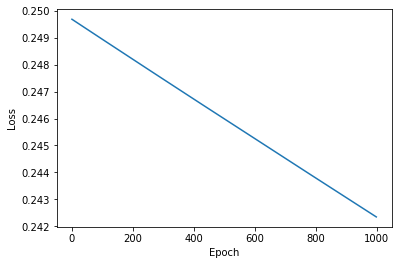

In [37]:
x_values = [i for i in range(n_steps)]

plt.plot(x_values, t_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(f"loss_{n_steps}_epochs")
plt.show()

## Test model

In [38]:
def classify(user_input):
    indices = make_text_into_numbers(user_input)
    # print(f"\"{user_input}\" => {indices}")
    question_tensor = torch.LongTensor([indices])
    output = net(question_tensor).detach().numpy()
    tag_index = np.argmax(output)
    return tag_index, output

In [45]:
def get_answer_from_tag(tag_index):
    tag = categories[tag_index]
    filtered_questions = df_questions[df_questions['tag'] == tag]
    sample = filtered_questions.sample()['answer'].values[0]
    return sample

In [ ]:
print("Chatbot: What can I help you with today?")
outputs = []

user_input = input("You: ")
while user_input != "Bye":
    tag_index, output = classify(user_input)
    outputs.append(output[0])
    answer = get_answer_from_tag(tag_index)
    print(f"Chatbot: {answer}")
    user_input = input("Question: ")

print("Chatbot: Have a nice day! Beep boop")

Chatbot: What can I help you with today?
You: Access an element in a dictionary
Chatbot: It sounds like you want to do something like:

&gt;&gt;&gt; d = {1: 2, 2: 4, 3: 6, 4: 8, 5: 10}
&gt;&gt;&gt; start = 1
&gt;&gt;&gt; end = 3
&gt;&gt;&gt; sum(d[i] for i in range(start, end + 1) if i in d)
12


This will sum the values from d for the keys 1-3 (inclusive).



### Evaluating outputs

In [ ]:
print(outputs[0][0], outputs[1][0], outputs[2][0])

In [ ]:
for i in range(len(categories)):
    print(outputs[0][i], outputs[1][i], outputs[2][i], outputs[3][i])

In [ ]:
df_outputs = pd.DataFrame(outputs, columns=categories, index=["text 1", "text 2", "text 3", "text 4"])
df_outputs = df_outputs.T
df_outputs